# Practical Machine Learning using R

### Loading study pre-requisite packages

In [61]:
suppressWarnings({library(ISLR); library(caret); library(dplyr); data(Wage); library(ggplot2); library(party)})

In [2]:
inTrain = createDataPartition(y = Wage$wage, p = 0.7, list = F)
train_raw = Wage[inTrain,]
test_raw = Wage[-inTrain,]
head(train_raw)

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
161300,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.98218
155159,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.68529
11443,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.04315
376662,2008,54,2. Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,4.845098,127.11574
450601,2009,44,2. Married,4. Other,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.133021,169.52854
377954,2008,30,1. Never Married,3. Asian,3. Some College,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.716003,111.72085


### Dummifying covariates 
Turning covariates which are qualitative into dummy variables is
common when training predictive models, since the models don't generally use
those qualitative information to do something productive.

In [3]:
dummies = dummyVars(wage~jobclass, data = train_raw)
head(predict(dummies, newdata = train_raw))

,jobclass.1. Industrial,jobclass.2. Information
161300,1,0
155159,0,1
11443,0,1
376662,0,1
450601,1,0
377954,0,1


### Removing zero or near-zero covariates
Removing the covariates that give no 
significant information that can be used in modelling a predictve model, they 
have very little to no variability and hence doesn't serve any purpose to the 
model creation. eg: In case of mails the column "any_letters" will certainly 
always be "True" since every mail will have atleast one letter in it. 

In [4]:
nsv = nearZeroVar(train_raw, saveMetrics=T)
nsv

,freqRatio,percentUnique,zeroVar,nzv
year,1.014368,0.33301618,FALSE,FALSE
age,1.109589,2.90199810,FALSE,FALSE
maritl,3.158009,0.23786870,FALSE,FALSE
race,8.504902,0.19029496,FALSE,FALSE
education,1.481641,0.23786870,FALSE,FALSE
region,0.000000,0.04757374,TRUE,TRUE
jobclass,1.036822,0.09514748,FALSE,FALSE
health,2.474380,0.09514748,FALSE,FALSE
health_ins,2.363200,0.09514748,FALSE,FALSE
logwage,1.048193,18.69647954,FALSE,FALSE


**Fitting curvy lines** in regression models by using basis function from **splines** package

In [5]:
suppressWarnings(library(splines))
bsBasis = bs(train_raw$age, df=3) # df specifies the order of function to which to tranform the original data
head(bsBasis)                     # The first column specifies the original data, 
                                  # second is raised to power 2,
                                  # and third - raised to power 3

1,2,3
0.4163380,0.3211750,0.082587862
0.4308138,0.2910904,0.065560908
0.3625256,0.3866940,0.137491189
0.3063341,0.4241549,0.195763821
0.4241549,0.3063341,0.073747105
0.3776308,0.0906314,0.007250512


**Illustration**

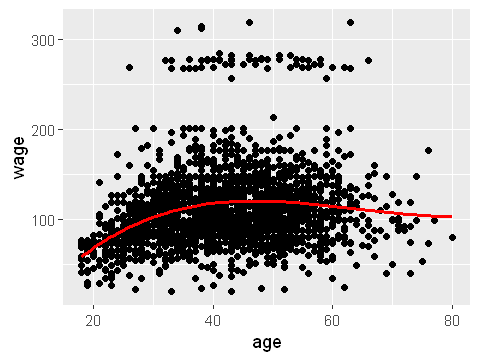

In [6]:
options(repr.plot.width=4, repr.plot.height=3)
fit = lm(wage ~ bsBasis, data = train_raw)
ggplot(train_raw,
      aes(x = age,y = wage)
      ) + geom_point() + geom_smooth(formula = "y ~ x+I(x**2)+I(x**3)", method = "lm", se = F, col = "red")

### PCA
To exclude unnecessary or too much information from a model while retaining a 
summarization of the covariates which captures most of the information we use
**PCA**.   


In [21]:
suppressWarnings({library(kernlab); data(spam)})
inTrain = createDataPartition(spam$type, p = 0.75, list = F)
train_raw = spam[inTrain,]
test_raw = spam[-inTrain,]

In [8]:
M = abs(cor(train_raw[,-58])) # Getting only absolute value to only understand correlation
diag(M) = 0 # removing diagonal coefficients which denotes the correlation of var with itself 
which(M>0.8,arr.ind=T)

,row,col
num415,34,32
direct,40,32
num857,32,34
direct,40,34
num857,32,40
num415,34,40


num415 and num857 seem to be highly correlated  

Visualizing 

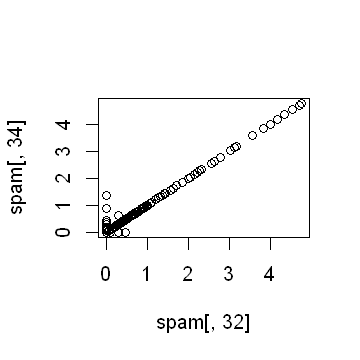

In [9]:
options(repr.plot.width=3, repr.plot.height=3)
plot(spam[,32],spam[,34])

Including both these predictors might not be useful since both are almost perfectly identical  
- PCA allows us to find new set of variables that aren't correlated with each 
other and explains as much of the variance as possible.   
- PCA is mathematically finding the lowest rank of matrix that explains the 
original data. This allows for data compression.   

The *prcomp()* function can be used to obtain the pricipal componenets of given 
data, 

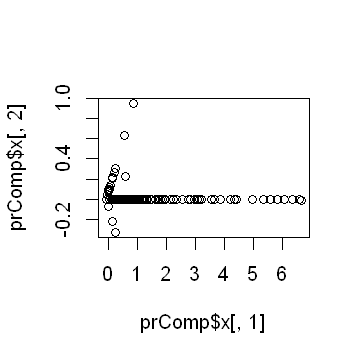

In [10]:
## Creating a subset of the data with just column 32 and 34 - the two highly 
## correlated columns in the dataset. 
smallspam = spam[,c(32,34)]
prComp = prcomp(smallspam)
plot(prComp$x[,1],prComp$x[,2])

In [11]:
prComp$rotation

,PC1,PC2
num857,0.7061498,-0.7080625
num415,0.7080625,0.7061498


Shows us that the principal component 1 is just the sum of the vector multiplication of the each row with corresponding column in the dataset.

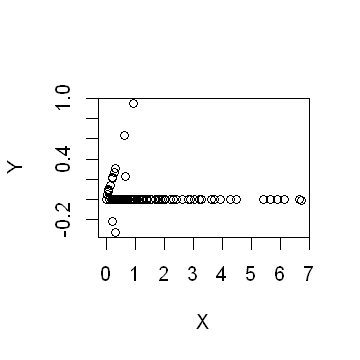

In [12]:
rot = prComp$rotation
X = rot[1,1]*train_raw$num857 + rot[2,1]*train_raw$num415
Y = rot[1,2]*train_raw$num857 + rot[2,2]*train_raw$num415
plot(X,Y)

As observed above, we get the same plot as with the principal components vectors

Using the PCA on the **entire dataset**

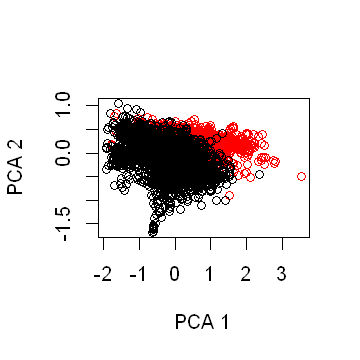

In [13]:
## defining a color encoded column vector which indicates the type of mail whether spam or ham
typeColor = ((spam$type=="spam")*1+1)
prComp = prcomp(log10(spam[,-58]+1)) # principal component analysis requires data to be normally distributed
plot(prComp$x[,1],prComp$x[,2], col = typeColor, xlab = "PCA 1", ylab = "PCA 2")

It is observed that most of the spam messages have higher values of PCA 1 and that it can certainly be used to classify messages by itself.

The caret package allows "pca" preprocessing on the dataset

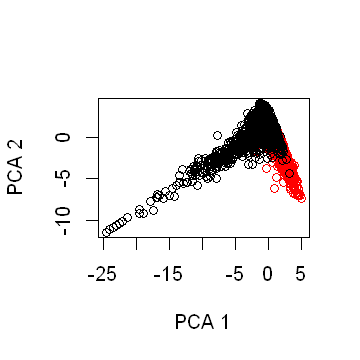

In [14]:
preProc = preProcess(log10(spam[,-58]+1), method = "pca", pcaComp = 2)
spamPC = predict(preProc, newdata = log10(spam[,-58]+1))
plot(spamPC[,1],spamPC[,2], col = typeColor, xlab = "PCA 1", ylab = "PCA 2")

Fitting a model using the data preprocessed with "pca" method

In [15]:
preProc = preProcess(log10(train_raw[,-58]+1), method = "pca", pcaComp = 2)
spamPC = predict(preProc, log10(train_raw[,-58]+1))
trainPC = mutate(spamPC, type= train_raw$type)
fit = suppressWarnings(train(type~., method = "glm", data=trainPC))

Testing the predictions

In [16]:
testPC = predict(preProc, newdata = log10(test_raw[,-58]+1))
preds = predict(fit, newdata = testPC)
confusionMatrix(preds, test_raw$type)

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     649   65
   spam         48  388
                                          
               Accuracy : 0.9017          
                 95% CI : (0.8831, 0.9183)
    No Information Rate : 0.6061          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.7929          
                                          
 Mcnemar's Test P-Value : 0.1323          
                                          
            Sensitivity : 0.9311          
            Specificity : 0.8565          
         Pos Pred Value : 0.9090          
         Neg Pred Value : 0.8899          
             Prevalence : 0.6061          
         Detection Rate : 0.5643          
   Detection Prevalence : 0.6209          
      Balanced Accuracy : 0.8938          
                                          
       'Positive' Class : nonspam         
               

Alternatively the above steps can be consolidated as 

In [19]:
fit = suppressWarnings(train(type~., method = "glm", preProcess = "pca", data=train_raw))
preds = predict(fit, newdata = test_raw)
confusionMatrix(preds, test_raw$type)

Confusion Matrix and Statistics

          Reference
Prediction nonspam spam
   nonspam     667   42
   spam         30  411
                                          
               Accuracy : 0.9374          
                 95% CI : (0.9218, 0.9507)
    No Information Rate : 0.6061          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8683          
                                          
 Mcnemar's Test P-Value : 0.1949          
                                          
            Sensitivity : 0.9570          
            Specificity : 0.9073          
         Pos Pred Value : 0.9408          
         Neg Pred Value : 0.9320          
             Prevalence : 0.6061          
         Detection Rate : 0.5800          
   Detection Prevalence : 0.6165          
      Balanced Accuracy : 0.9321          
                                          
       'Positive' Class : nonspam         
               

## Decision Tree Classifiers
Using rpart method in training    
and fancyRpartPlot() from "rattle" package to visualize the tree structure  

In [1]:
data(iris)
names(iris)

[1] "Sepal.Length" "Sepal.Width"  "Petal.Length" "Petal.Width"  "Species"

In [2]:
table(iris$Species)


    setosa versicolor  virginica 
        50         50         50 

In [9]:
inTrain = createDataPartition(iris$Species, p = 0.75, list = F)
training = iris[inTrain,]
testing  = iris[-inTrain,]
dim(training); dim(testing)

[1] 114   5

[1] 36  5

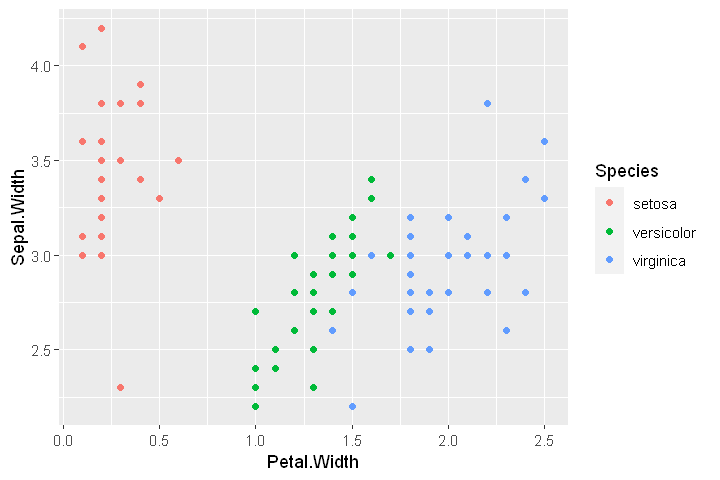

In [24]:
options(repr.plot.width=6, repr.plot.height=4)
qplot(data = training, x = Petal.Width, y = Sepal.Width, color = Species)

In [18]:
mdl = train(Species~., method = "rpart", data = training)
print(mdl$finalModel)

n= 114 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 114 76 setosa (0.33333333 0.33333333 0.33333333)  
  2) Petal.Length< 2.45 38  0 setosa (1.00000000 0.00000000 0.00000000) *
  3) Petal.Length>=2.45 76 38 versicolor (0.00000000 0.50000000 0.50000000)  
    6) Petal.Length< 4.75 35  0 versicolor (0.00000000 1.00000000 0.00000000) *
    7) Petal.Length>=4.75 41  3 virginica (0.00000000 0.07317073 0.92682927) *


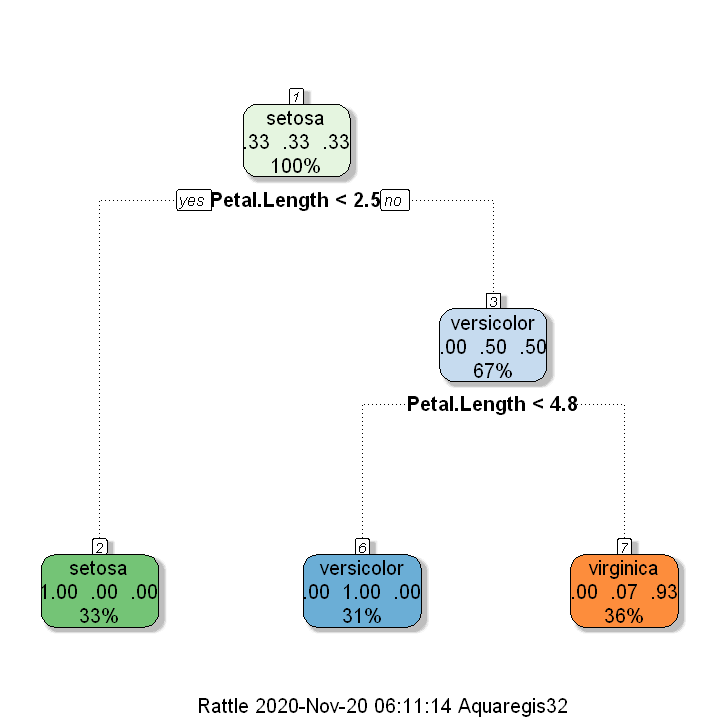

In [27]:
library(rattle)
options(repr.plot.width=6, repr.plot.height=6)
fancyRpartPlot(mdl$finalModel)

In [28]:
confusionMatrix(testing$Species, predict(mdl, newdata = testing[,-5]))

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         12          0         0
  versicolor      0          9         3
  virginica       0          1        11

Overall Statistics
                                          
               Accuracy : 0.8889          
                 95% CI : (0.7394, 0.9689)
    No Information Rate : 0.3889          
    P-Value [Acc > NIR] : 6.655e-10       
                                          
                  Kappa : 0.8333          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 1.0000            0.9000           0.7857
Specificity                 1.0000            0.8846           0.9545
Pos Pred Value              1.0000            0.7500           0.9167
Neg Pred Value              1.0000            0.9583           0.8750
P

### Bagging
Modelling methods available in caret package that performs bagging implicitely:  
- bagEarth  
- treebag  
- bagFDA  

Bagging can be used in any modelling technique using the bag function  

**Illustration of bagging** 

In [52]:
loessList = matrix(NA, nrow = 10, ncol = 100)
for(i in 1:10){
    subSample = sample(1:nrow(Wage), replace = T)
    Wage0 = Wage[subSample,]; Wage0 = Wage0[order(Wage0$wage),]
    loess0 = loess(wage~age, data = Wage0, span = 0.2)
    loessList[i,] = predict(loess0, newdata = data.frame(age = 1:100))
}

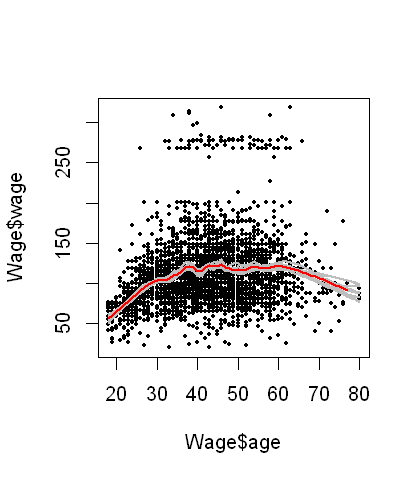

In [56]:
options(repr.plot.width=3.5, repr.plot.height=4)
plot(Wage$age, Wage$wage, pch = 19, cex = 0.5)
for(i in 1:10){
    lines(1:100, loessList[i,], col = "grey", lwd = 2)
}
lines(1:100, apply(loessList, 2, mean), col = "red", lwd = 2)

The grey lines represent the loess lines for predictions from each of the samples, whereas the red line represent their average.  

### Performing bagging in caret

In [62]:
predictors = data.frame(age = Wage$age)
wage = Wage$wage
treeBag = bag(predictors, wage, B = 10, 
              bagControl = bagControl(fit = ctreeBag$fit, 
                                      predict = ctreeBag$pred, 
                                      aggregate = ctreeBag$aggregate))

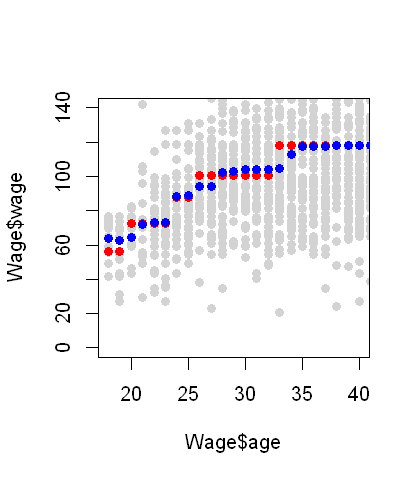

In [73]:
plot(Wage$age, Wage$wage, col = "lightgrey", pch = 19,xlim = c(18,40), ylim = c(0,140))
points(Wage$age, predict(treeBag$fits[[1]]$fit, predictors), pch = 19, col = alpha("red",0.4))
points(Wage$age, predict(treeBag, predictors), pch = 19, col = alpha("blue",0.4))